Copyright (c) Microsoft Corporation. All rights reserved. Licensed under the MIT License.

# Capture The Flag Toy Example - Solved manually

This notebook demonstrates how to model a toy `Capture The Flag` security game as a CyberBattle environment.

In [1]:
import sys, logging
import cyberbattle.simulation.model as model
import cyberbattle.simulation.commandcontrol as commandcontrol
import cyberbattle.samples.toyctf.toy_ctf as ctf
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s: %(message)s")

import plotly.offline as plo
plo.init_notebook_mode(connected=True)

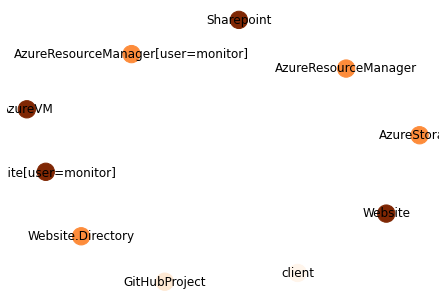

In [2]:
network = model.create_network(ctf.nodes)
env = model.Environment(network=network, vulnerability_library=dict([]),identifiers=ctf.ENV_IDENTIFIERS)
env.plot_environment_graph()

### Solution to the CTF

This is the list of actions taken to capture 7 of the 8 flags from the CTF game.

| Source      | Action | Result |
|------------ | ------ | ------ |
| WEBSITE     | page content has a link to github       | Discover Github project |
| GITHUB      | navigate github history                 | **FLAG** Some secure access token (SAS) leaked in a reverted git commit (`CredScan`) |
| AZURESTORAGE| access blob using SAS token             | |
| WEBSITE     | view source HTML                        | Find URL to hidden .txt file on the website, extract directory path from it |
|             | navigate to parent URL and find 3 files | **FLAG** Discover browseable web directory |
|             | - readme.txt file                       | Discover secret data (the flag) | 
|             | - getting-started.txt                   | Discover MYSQL credentials | 
|             | - deprecation-checklist.txt             | Discover URL to external sharepoint website | 
| SHAREPOINT  | Navigate to sharepoint site             | **FLAG** Finding AD Service Principal Credentials on Sharepoint | 
| CLIENT-AZURE| `az resource` with creds from sharepoint| Obtain secrets hidden in azure managed resources |
|             |                                         | Get AzureVM info, including public IP address |
| CLIENT      | `ssh IP`                                | Failed attempt: internet incoming traffic blocked on the VM by NSG |
| CLIENT      | SSH into WEBSITE with  mysql creds      | **FLAG** Shared credentials with database user|
|             |                                         |**FLAG** Login using insecure SSH user/password|
| WEBSITE/SSH | `history`                               |**FLAG**  Stealing credentials for the monitoring user|
|             | `sudo -u monitor`                        | Failed! monitor not sudoable. message about being reported!
| CLIENT      | SSH into WEBSITE with 'monitor creds     | Failed! password authentication disabled! looking for private key|
| CLIENT      | SSH into WEBSITE as 'web'               | |
|             | `su -u monitor` using password           |**FLAG**  User escalation by stealing credentials from bash history|
|             | `cat ~/azurecreds.txt`                  | Get user credentials to Azure
| CLIENT      | `az resource` with monitor's creds       | Steal more secrets


In [3]:
c2 = commandcontrol.CommandControl(env)
dbg = commandcontrol.EnvironmentDebugging(c2)

# 1 - Start from client
dbg.plot_discovered_network()

In [4]:
c2.print_all_attacks()

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]


In [5]:
outcome = c2.run_attack('client', 'SearchEdgeHistory')
dbg.plot_discovered_network()

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


In [6]:
c2.print_all_attacks()

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]
1,Website,discovered,NaN,None,"[ScanPageSource, ScanPageContent]"


In [7]:
# 2
github = c2.run_remote_attack('client', 'Website', 'ScanPageContent')
dbg.plot_discovered_network()

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


In [8]:
c2.print_all_attacks()

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]
1,Website,discovered,NaN,None,"[ScanPageSource, ScanPageContent]"
2,GitHubProject,discovered,NaN,None,[CredScanGitHistory]


In [9]:
# 3
leakedSasUrl = c2.run_remote_attack('client', 'GitHubProject',  'CredScanGitHistory')
dbg.plot_discovered_network()

INFO: discovered node: AzureStorage
INFO: discovered credential: CachedCredential(node='AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


In [12]:
# 4
blobwithflag = c2.connect_and_infect('client', 'AzureStorage', 'HTTPS', 'SASTOKEN1')
dbg.plot_discovered_network()
blobwithflag

True

In [13]:
# 5
browsableDirectory = c2.run_remote_attack('client', 'Website', 'ScanPageSource')
dbg.plot_discovered_network()

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


In [14]:
# 6 
outcome_mysqlleak = c2.run_remote_attack('client', 'Website.Directory', 'NavigateWebDirectoryFurther')
sharepoint_url = c2.run_remote_attack('client', 'Website.Directory', 'NavigateWebDirectory')
dbg.plot_discovered_network()

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


In [15]:
# 7
outcome_azure_ad = c2.run_remote_attack('client', 'Sharepoint', 'ScanSharepointParentDirectory')
dbg.plot_discovered_network()

INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials


In [16]:
# 8 
azureVmInfo = c2.connect_and_infect('client', 'AzureResourceManager', 'HTTPS', 'ADPrincipalCreds')
dbg.plot_discovered_network()

INFO: Infected node 'AzureResourceManager' from 'client' via HTTPS with credential 'ADPrincipalCreds'
INFO: Owned message: FLAG: Shared credentials with database user - Obtained secrets hidden in Azure Managed Resources


In [17]:
c2.run_remote_attack('client', 'AzureResourceManager', 'ListAzureResources')
dbg.plot_discovered_network()

INFO: discovered node: AzureVM
INFO: GOT REWARD: Obtained Azure VM and public IP information


In [18]:
# 9 - CLIENT: Attempt to SSH into AzureVM from IP retrieved from Azure Resource Manager
should_fail = c2.connect_and_infect('client', 'AzureVM', 'SSH', 'ReusedMySqlCred-web')
print('Success=' + str(should_fail))
dbg.plot_discovered_network()

INFO: BLOCKED TRAFFIC: target node 'AzureVM' is blocking outgoing traffic on port 'SSH'
Success=False


In [19]:
# 10
owned = c2.connect_and_infect('client', 'Website', 'SSH', 'ReusedMySqlCred-web')
dbg.plot_discovered_network()

INFO: Infected node 'Website' from 'client' via SSH with credential 'ReusedMySqlCred-web'
INFO: Owned message: FLAG: Login using insecure SSH user/password


In [20]:
# 11
outcome = c2.run_attack('Website', 'CredScanBashHistory')
dbg.plot_discovered_network()

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


In [21]:
c2.print_all_attacks()

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]
1,Website,owned,"[MySql, Ubuntu, nginx/1.10.3]",[CredScanBashHistory],"[ScanPageSource, ScanPageContent]"
2,AzureStorage,owned,[CTFFLAG:LeakedCustomerData],[],[AccessDataWithSASToken]
3,AzureResourceManager,owned,[CTFFLAG:LeakedCustomerData2],[],[ListAzureResources]
4,GitHubProject,discovered,NaN,None,[CredScanGitHistory]
5,Website.Directory,discovered,NaN,None,"[NavigateWebDirectoryFurther, NavigateWebDirec..."
6,Sharepoint,discovered,NaN,None,[ScanSharepointParentDirectory]
7,AzureVM,discovered,NaN,None,[]
8,Website[user=monitor],discovered,NaN,None,[]


In [22]:
# 12
should_fail = c2.connect_and_infect('Website', 'Website[user=monitor]', 'sudo', 'monitorBashCreds')
dbg.plot_discovered_network()

INFO: BLOCKED TRAFFIC: target node 'Website[user=monitor]' is blocking outgoing traffic on port 'sudo'


In [23]:
# 13
should_fail = c2.connect_and_infect('client', 'Website[user=monitor]', 'SSH', 'monitorBashCreds')
dbg.plot_discovered_network()
should_fail

INFO: BLOCKED TRAFFIC: target node 'Website[user=monitor]' is blocking outgoing traffic on port 'SSH'


False

In [24]:
# 14
flag = c2.connect_and_infect('Website', 'Website[user=monitor]', 'su', 'monitorBashCreds')
dbg.plot_discovered_network()

INFO: Infected node 'Website[user=monitor]' from 'Website' via su with credential 'monitorBashCreds'
INFO: Owned message: FLAG User escalation by stealing credentials from bash history


In [25]:
# 15
outcome = c2.run_attack('Website[user=monitor]', 'CredScan-HomeDirectory')
dbg.plot_discovered_network()

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


In [26]:
# 16
secrets = c2.connect_and_infect('client', 'AzureResourceManager[user=monitor]', 'HTTPS', 'azuread_user_credentials')
dbg.plot_discovered_network()

INFO: Infected node 'AzureResourceManager[user=monitor]' from 'client' via HTTPS with credential 'azuread_user_credentials'
INFO: Owned message: More secrets stolen when logged as interactive `monitor` user in Azure with `az`


In [27]:
c2.print_all_attacks()

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]
1,Website,owned,"[MySql, Ubuntu, nginx/1.10.3]",[CredScanBashHistory],"[ScanPageSource, ScanPageContent]"
2,AzureStorage,owned,[CTFFLAG:LeakedCustomerData],[],[AccessDataWithSASToken]
3,AzureResourceManager,owned,[CTFFLAG:LeakedCustomerData2],[],[ListAzureResources]
4,Website[user=monitor],owned,"[MySql, Ubuntu, nginx/1.10.3]",[CredScan-HomeDirectory],[]
5,AzureResourceManager[user=monitor],owned,[],[],[]
6,GitHubProject,discovered,NaN,None,[CredScanGitHistory]
7,Website.Directory,discovered,NaN,None,"[NavigateWebDirectoryFurther, NavigateWebDirec..."
8,Sharepoint,discovered,NaN,None,[ScanSharepointParentDirectory]
9,AzureVM,discovered,NaN,None,[]
